In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib as mpl
import pickle
from copy import copy
from tqdm import tqdm_notebook as tqdm
from importlib import reload

import readdy_learn.example.mapk as mapk

/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/lm.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)
/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/mystyle-lm.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)
/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/mystyle-lm-small.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)


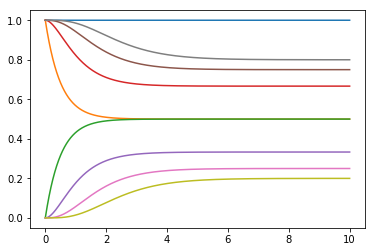

In [2]:
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()
time, count, dcount_dt = mapk.generate_lma(10, cfg)

plt.plot(time, count)
plt.show()

In [16]:
activities = []
X = np.logspace(-3, 3, num=100)
for N_STIMULUS in tqdm(X):
    mapk.TIMESTEP = 1e-3
    mapk.INITIAL_STATES[0][0] = N_STIMULUS
    time, count, dcount_dt = mapk.generate_lma(10, cfg)
    activities.append(count[-1, -1])
mapk.TIMESTEP = 1e-3
mapk.N_STIMULUS = 1
mapk.INITIAL_STATES[0][0] = mapk.N_STIMULUS
cfg = mapk.MAPKConfiguration()

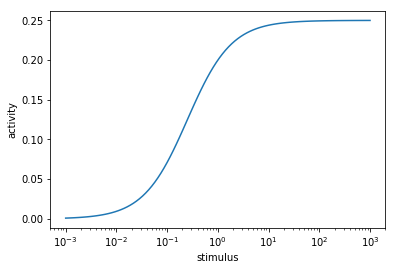

In [17]:
plt.semilogx(X, activities)
plt.xlabel('stimulus')
plt.ylabel('activity')
plt.show()

In [3]:
mapk=reload(mapk)
cfg = mapk.MAPKConfiguration()

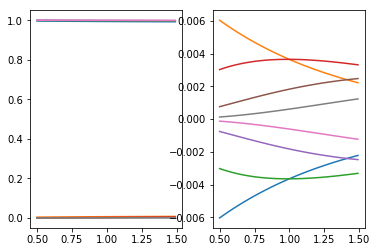

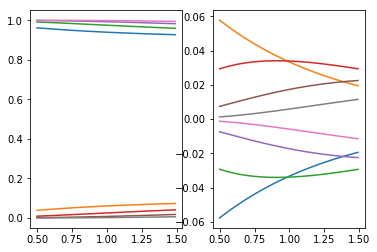

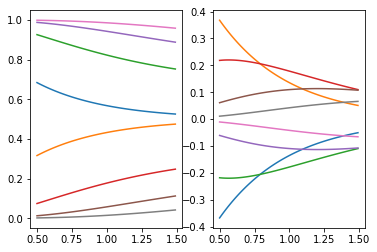

In [12]:
data = []
for N_STIMULUS in [1e-2, 1e-1, 1e0]:
    # mapk.TIMESTEP = 3e-2 # works well
    #mapk.TIMESTEP = 5e-3 # 2.7 works better
    mapk.TIMESTEP = 1e-2
    
    X = copy(mapk.INITIAL_STATES)
    X[0][0] = N_STIMULUS
    mapk.INITIAL_STATES = X
    time, count, dcount_dt = mapk.generate_lma(2, cfg)
    
    # only use middle snippet
    begin = len(time) // 4
    end = 3 * begin
    time = time[begin:end]
    count = count[begin:end]
    dcount_dt = dcount_dt[begin:end]
    
    # time, count, dcount_dt = mapk.generate_kmc(0, .003, n_realizations=15, njobs=5)
    data.append((time, count, dcount_dt))
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(time, count[:, 1:])
    ax2.plot(time, dcount_dt[:, 1:])
    # plt.plot(time, count[:, 1:])
    f.show()

In [13]:
time = np.concatenate([data[i][0] for i in range(len(data))])
counts = np.concatenate([data[i][1] for i in range(len(data))])
dcounts_dt = np.concatenate([data[i][2] for i in range(len(data))])

# shuffle
N = np.arange(len(time))
np.random.shuffle(N)
shuffled_time = time[N]
shuffled_counts = counts[N]
shuffled_dcounts_dt = dcounts_dt[N]

In [14]:
len(time)

300

In [15]:
result = mapk.solve_grid(cfg, shuffled_counts, shuffled_dcounts_dt, l1_ratios=(1.,), 
                         alphas=np.logspace(-10, -6, num=20), njobs=2)

Trying tolerance 1e-16
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
186 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.6237767391887243e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
186 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.6366508987303556e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
186 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.281332398719396e-10, lambda=1.0)!
status 0: Optimization terminated successfully.
186 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1288378916846883e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
185 / 5000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.951927961775591e-10,

In [16]:
alphas = np.array([res[0] for res in result])
sort = np.argsort(alphas)
alphas = alphas[sort]
estimated_rates = np.array([res[2] for res in result])
estimated_rates = estimated_rates[sort]
l1_errs = np.sum(np.abs(estimated_rates - cfg.rates), axis=1)

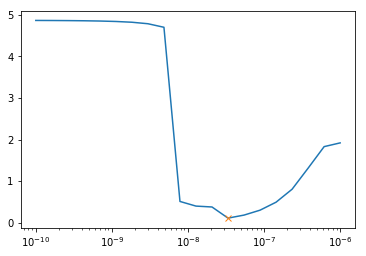

In [17]:
plt.semilogx(alphas, l1_errs)
plt.plot([alphas[np.argmin(l1_errs)]], [l1_errs[np.argmin(l1_errs)]], 'x')

In [18]:
alphas[np.argmin(l1_errs)]

3.3598182862837814e-08

In [19]:
best_estimated_rates = estimated_rates[np.argmin(l1_errs)]

In [20]:
np.abs(((estimated_rates[0][:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([6.40108723e-05, 6.35695575e-05, 6.17074974e-05, 3.33258362e-01,
       1.35032051e-03, 7.00445971e-01, 6.02009872e-03, 6.23491082e-01])

In [21]:
np.abs(((best_estimated_rates[:8] - cfg.rates[:8]) / cfg.rates[:8]))

array([5.39326302e-05, 4.95962695e-05, 8.09396533e-05, 1.44396446e-04,
       3.11522865e-03, 3.85022851e-03, 3.83176162e-02, 6.47254179e-02])

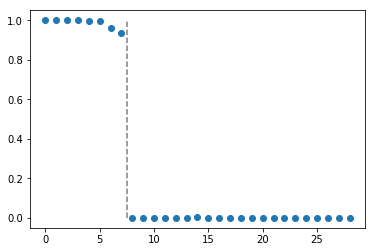

In [22]:
plt.plot(best_estimated_rates, 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

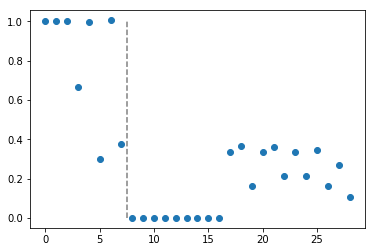

In [23]:
plt.plot(estimated_rates[0], 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

In [24]:
cv_result = mapk.cv(cfg, shuffled_counts, shuffled_dcounts_dt, 
                    alphas=np.logspace(-9.5, -7.5, 40), n_splits=15, njobs=2)

validating across grid with 40 alphas, 1 lambdas, 1 cutoffs with 1 realizations


Running kfold with n_splits=15
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Solving for tolerance 1e-16
Test: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Solving for tolerance 1e-16
Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Solving for tolerance 1e-16
Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Solving for tolerance 1e-16
Test: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
Solving for tolerance 1e-16
Test: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
Solving for tolerance 1e-16
Test: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Solving for tolerance 1e-16
Test: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Solvin

Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
Solving for tolerance 1e-16
Test: [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
Solving for tolerance 1e-16
Test: [220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

 278 279]
Solving for tolerance 1e-16
Test: [260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Solving for tolerance 1e-16
Test: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Solving for tolerance 1e-16
Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Solving for tolerance 1e-16
Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
S

 118 119]
Solving for tolerance 1e-16
Test: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119]
Solving for tolerance 1e-16
Test: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Solving for tolerance 1e-16
Test: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [180 181 182 183 184

 238 239]
Solving for tolerance 1e-16
Test: [240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259]
Solving for tolerance 1e-16
Test: [240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259]
Solving for tolerance 1e-16
Test: [260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279]
Solving for tolerance 1e-16
Test: [260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: 

Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Solving for tolerance 1e-16
Test: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119]
Solving for tolerance 1e-16
Test: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
Solving for tolerance 1e-16
Test: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [120

 178 179]
Solving for tolerance 1e-16
Test: [240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279]
Solving for tolerance 1e-16
Test: [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Test: [220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: [240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259]
Solving for tolerance 1e-16
Test: [20 21 22 

 298 299]
Solving for tolerance 1e-16
Test: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Solving for tolerance 1e-16
Running kfold with n_splits=15
Test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Solving for tolerance 1e-16
Test: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119]
Solving for tolerance 1e-16
Test: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Solving for tolerance 1e-16
Test: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Solving for tolerance 1e-16
Test: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for

 238 239]
Solving for tolerance 1e-16
Test: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139]
Solving for tolerance 1e-16
Test: [240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259]
Solving for tolerance 1e-16
Test: [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159]
Solving for tolerance 1e-16
Test: [260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279]
Solving for tolerance 1e-16
Test: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Solving for tolerance 1e-16
Test: [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299]
Solving for tolerance 1e-16
Test: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Solving for tolerance 1e-16
Test: [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
Solving for tolerance 1e-16
Test: [220 221 222 223 224

In [25]:
alphas = []
scores = []
for res in cv_result['cv_result']:
    alphas.append(res['alpha'])
    scores.append(np.mean(res['score']))
alphas = np.array(alphas)
scores = np.array(scores)
N = np.argsort(alphas)
alphas = alphas[N]
scores = scores[N]

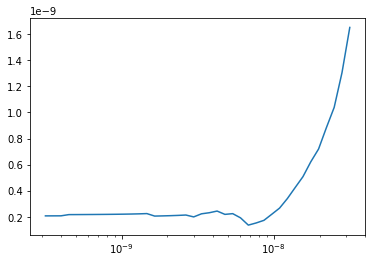

In [29]:
%matplotlib inline
plt.semilogx(alphas, -scores)
#plt.ylim([4.447e8, 4.46e8])

In [27]:
X = np.argmin(-scores)

In [28]:
alphas[X]

6.812920690579622e-09

In [31]:
estimated_rates = mapk.solve(cfg, counts, dcounts_dt, alpha=alphas[X], l1_ratio=1.)

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.812920690579622e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
277 / 5000 iterations


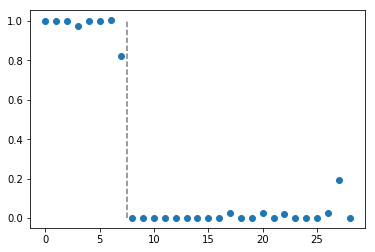

In [33]:
plt.plot(estimated_rates, 'o')
plt.vlines([7.5], 0, 1, 'grey', 'dashed')

In [32]:
estimated_rates

array([1.00006196e+00, 1.00006073e+00, 9.99932016e-01, 9.73536761e-01,
       9.99446521e-01, 9.99291729e-01, 1.00435996e+00, 8.23722363e-01,
       0.00000000e+00, 3.47834347e-08, 4.16077333e-21, 1.09684860e-04,
       0.00000000e+00, 3.76339731e-21, 1.87025188e-18, 0.00000000e+00,
       5.37384760e-07, 2.63257908e-02, 0.00000000e+00, 7.64694347e-17,
       2.63667019e-02, 0.00000000e+00, 1.97691223e-02, 0.00000000e+00,
       2.35148061e-17, 3.36201264e-16, 2.42437480e-02, 1.92547538e-01,
       0.00000000e+00])

# Tupelgeraffel

In [53]:
tuples = tuple((i, j) for i in range(1, 9) for j in range(9) if j > i)

In [54]:
pairs = tuple((tuples[i], tuples[j]) for i in range(len(tuples)) for j in range(len(tuples)) if j != i
             and tuples[i][0] == tuples[j][0] and tuples[i][1] - tuples[j][1] == -1 and tuples[i][1] % 2 == 1)

In [55]:
pairs = [(pairs[i][0], pairs[i][1]) for i in range(len(pairs))] 
        + [(pairs[i][1], pairs[i][0]) for i in range(len(pairs))]

In [56]:
pairs

[((1, 3), (1, 4)),
 ((1, 5), (1, 6)),
 ((1, 7), (1, 8)),
 ((2, 3), (2, 4)),
 ((2, 5), (2, 6)),
 ((2, 7), (2, 8)),
 ((3, 5), (3, 6)),
 ((3, 7), (3, 8)),
 ((4, 5), (4, 6)),
 ((4, 7), (4, 8)),
 ((5, 7), (5, 8)),
 ((6, 7), (6, 8)),
 ((1, 4), (1, 3)),
 ((1, 6), (1, 5)),
 ((1, 8), (1, 7)),
 ((2, 4), (2, 3)),
 ((2, 6), (2, 5)),
 ((2, 8), (2, 7)),
 ((3, 6), (3, 5)),
 ((3, 8), (3, 7)),
 ((4, 6), (4, 5)),
 ((4, 8), (4, 7)),
 ((5, 8), (5, 7)),
 ((6, 8), (6, 7))]